In [1]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
comments = pd.read_csv("../data/vtaiwan/comments_translated.csv")
comments.head()

,timestamp,datetime,comment-id,author-id,agrees,disagrees,moderated,comment-body,translated_comment
0,1436965020,Wed Jul 15 2015 12:57:00 GMT+0000 (Coordinated...,18,0,351,351,1,我覺得UberX目前未依法營業，讓我覺得搭乘時有風險。,I feel that UberX is not currently operating i...
1,1436965031,Wed Jul 15 2015 12:57:11 GMT+0000 (Coordinated...,19,0,365,327,1,我覺得UberX管理制度不夠透明，讓我難以安心。,I feel that UberX’s management system is not t...
2,1436965038,Wed Jul 15 2015 12:57:18 GMT+0000 (Coordinated...,21,0,505,186,1,我覺得UberX應該依法令申請經營運輸業務。,I think UberX should apply to operate transpor...
3,1436965034,Wed Jul 15 2015 12:57:14 GMT+0000 (Coordinated...,20,0,312,385,1,我覺得UberX已與現有國內運輸業產生不公平競爭的情形。,I feel that UberX has created unfair competiti...
4,1437097446,Fri Jul 17 2015 01:44:06 GMT+0000 (Coordinated...,22,88,1,0,-1,我覺得每位司機都該投保乘客責任險,I think every driver should have passenger lia...


In [3]:
votes = pd.read_csv("../data/vtaiwan/participant-votes.csv")
votes.head()

,participant,group-id,n-comments,n-votes,n-agree,n-disagree,0,1,2,3,...,189,190,191,192,193,194,195,196,197,198
0,0,0.0,46,101,44,12,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1.0,0,29,14,10,1.0,-1.0,-1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,1.0,5,88,58,15,1.0,-1.0,-1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,1.0,0,31,13,16,1.0,-1.0,-1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,0.0,0,11,0,0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
votes_matrix = votes.set_index("participant").iloc[:, 5:]
votes_matrix = votes_matrix.T
votes_matrix.index = votes_matrix.index.rename("comment_id")
votes_matrix

participant,0,1,2,4,5,7,8,9,10,11,...,4961,4962,4963,4964,4965,4966,4967,4968,4969,4970
comment_id,,,,,,,,,,,,,,,,,,,,,
0,1.0,1.0,1.0,1.0,0.0,-1.0,NaN,1.0,1.0,1.0,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,-1.0,-1.0,-1.0,0.0,NaN,NaN,-1.0,NaN,-1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,-1.0,-1.0,-1.0,0.0,1.0,NaN,-1.0,NaN,-1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.0,1.0,1.0,1.0,0.0,1.0,NaN,1.0,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
4,1.0,1.0,1.0,1.0,0.0,1.0,NaN,1.0,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
195,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
196,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


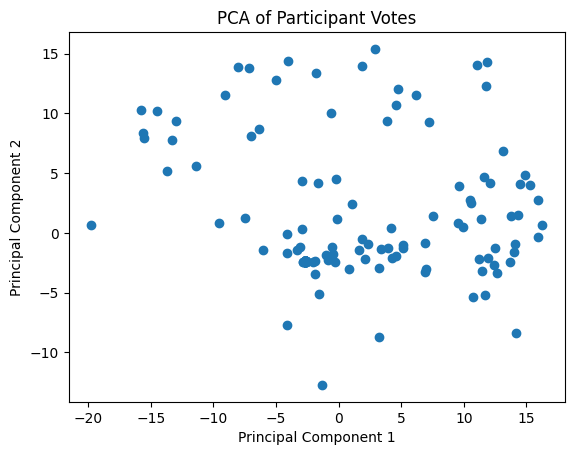

In [5]:
def decompose_votes(vote_matrix: np.ndarray, num_components: int = 2):
    pca = PCA(n_components=num_components)

    vote_matrix_nonan = np.nan_to_num(vote_matrix, nan=0)
    transformed = pca.fit_transform(vote_matrix_nonan)

    total_votes = np.sum(~np.isnan(vote_matrix_nonan), axis=1)
    vote_scale = np.sum(~np.isnan(vote_matrix_nonan), axis=1)
    vote_scale = np.sqrt(total_votes / (vote_scale + 1e-10))

    return transformed * vote_scale[:, None], pca


decomposed_votes, pca_model = decompose_votes(votes_matrix.values)
decomposed_df = pd.DataFrame(
    decomposed_votes, columns=["x", "y"], index=votes_matrix.index
)

plt.scatter(decomposed_df["x"], decomposed_df["y"])
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA of Participant Votes")
plt.show()

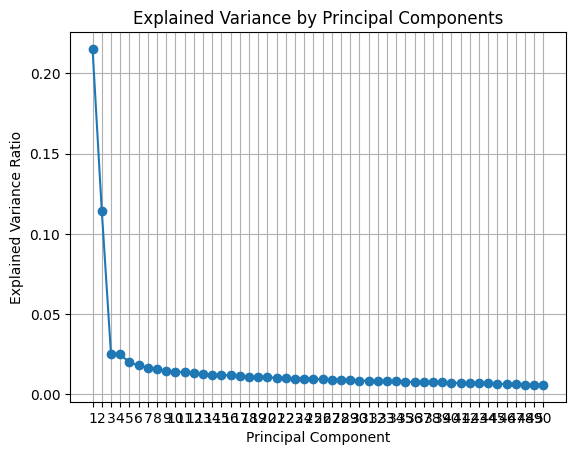

In [6]:
num_components_model = 50
num_components = 7
decomposed_highdim, pca_highdim = decompose_votes(
    votes_matrix.values, num_components=num_components_model
)
explained_variance = pca_highdim.explained_variance_ratio_
plt.plot(range(1, num_components_model + 1), explained_variance, marker="o")
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.title("Explained Variance by Principal Components")
plt.xticks(range(1, num_components_model + 1))
plt.grid()
plt.show()

In [7]:
# pick 10 comments per principal component
num_comments_per_component = 10
num_components_for_rating = 20
top_comments = []
for i in range(num_components_for_rating):
    component_scores = pca_highdim.components_[i]
    top_indices = np.argsort(np.abs(component_scores))[-num_comments_per_component:]
    top_comments.extend(top_indices)

top_comments_df = pd.DataFrame(top_comments, columns=["comment-id"])
top_comments_df = top_comments_df.drop_duplicates().reset_index(drop=True)
top_comments_df = top_comments_df.merge(comments[["comment-id", "translated_comment"]], on="comment-id", how="left")

# save and rate on variable, e.g., "pro-uber"
ratings_df = top_comments_df
ratings_df["rating"] = 0
ratings_df.to_csv("../data/vtaiwan/ratings-unfilled.csv", index=False)

In [8]:
# read it back and analyze
ratings_df = pd.read_csv("../data/vtaiwan/ratings.csv")
ratings_df

,comment-id,translated_comment,rating
0,67,Uber has the opportunity to take high-end cars...,1
1,46,"I think the concept of sharing a ride, but wit...",1
2,84,I think traditional taxis now have to join fle...,2
3,71,I think UBER is a concept of a sharing platfor...,0
4,66,I think Uber drivers are less likely to drive ...,0
5,30,I think UberX’s current illegal behavior shoul...,-1
6,62,I believe that UBER is a business model that c...,1
7,39,I think UberX has better quality than taxis on...,0
8,53,I think UBER is a new service that benefits bo...,1
9,38,"If I am not in a hurry, I would still prefer t...",1


In [9]:
# linear regression on PCA components
X = decomposed_highdim[ratings_df["comment-id"].values, :num_components]
y = ratings_df["rating"].values

r_train = []
r = []
coef = []
for i in range(20):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)

    model = LinearRegression()
    model.fit(X_train, y_train)
    score_train = np.corrcoef(model.predict(X_train), y_train)[0, 1]
    r_train.append(score_train)

    pred = model.predict(X_test)
    score = np.corrcoef(pred, y_test)[0, 1]
    r.append(score)
    coef.append(model.coef_)

    # plt.scatter(pred, y_test)
    # plt.xlabel("Predicted Ratings")
    # plt.ylabel("Actual Ratings")
    # plt.title("Predicted vs Actual Ratings")
    # plt.grid()
    # plt.show()

print(f"Average R (train): {np.mean(r_train):.3f} ± {np.std(r_train):.3f}")
print(f"Average R: {np.mean(r):.3f} ± {np.std(r):.3f}")
print(f"Average Coefficients: ")
for i in range(num_components):
    print(f"Component {i+1}: {np.mean([c[i] for c in coef]):.3f} ± {np.std([c[i] for c in coef]):.3f}")

Average R (train): 0.772 ± 0.069
Average R: 0.443 ± 0.181
Average Coefficients: 
Component 1: 0.060 ± 0.021
Component 2: -0.030 ± 0.034
Component 3: 0.076 ± 0.057
Component 4: 0.053 ± 0.050
Component 5: 0.006 ± 0.042
Component 6: -0.064 ± 0.043
Component 7: -0.045 ± 0.052


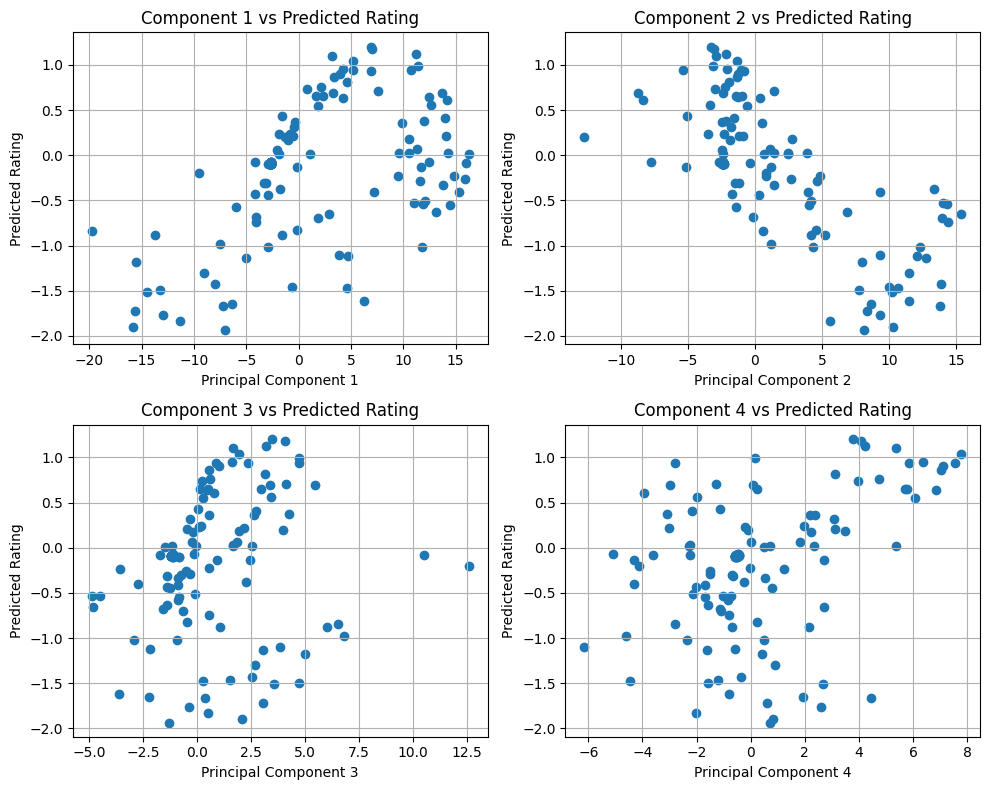

In [10]:
# project to all comments and see how ratings correlate with first 4 components
all_comments_projection = model.predict(decomposed_highdim[:, :num_components])
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))
for i in range(4):
    ax[i // 2, i % 2].scatter(decomposed_highdim[:, i], all_comments_projection)
    ax[i // 2, i % 2].set_xlabel(f"Principal Component {i+1}")
    ax[i // 2, i % 2].set_ylabel("Predicted Rating")
    ax[i // 2, i % 2].set_title(f"Component {i+1} vs Predicted Rating")
    ax[i // 2, i % 2].grid()
plt.tight_layout()